O banco de dados MNIST é um grande banco de dados de dígitos manuscritos, comumente usado para treinar vários sistemas de processamento de imagens. O banco de dados também é amplamente utilizado para treinamento e teste no campo do aprendizado de máquina.

A base de dados do MNIST contém 60.000 imagens de preparação e 10.000 imagens de teste. 

É um tipo de Rede Neural usada para resolver problemas numéricos - números escritos à mão. 

In [18]:
import numpy as np
import torch
import torch.nn.functional as F 
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim


In [19]:
transform = transforms.ToTensor() #definindo a conversão de imagem para tensor

trainset = datasets.MNIST('./MNIST_data/', download=True, train=True, transform=transform) # Carrega a parte de treino do dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True) # Carrega um buffer para pegar os dados por partes

valset = datasets.MNIST('./MNIST_data/', download=True, train=True, transform=transform)  # Carrega a parte de validação
valloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)   # Cria um buffer para pegar os dados por partes

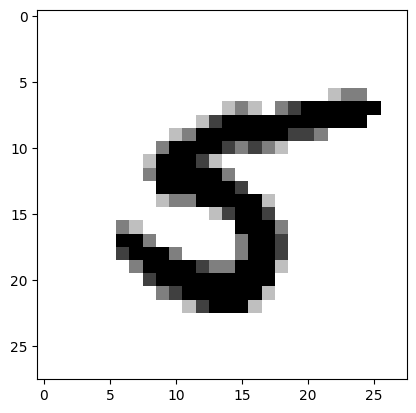

In [20]:
dataiter = iter(trainloader)
imagens, etiquetas = next(dataiter)
plt.imshow(imagens[0].numpy().squeeze(), cmap='gray_r');  # Exibe a primeira imagem do lote


In [21]:
print(imagens[0].shape)     #para verificar as dimensões do tensor de cada imagem
print(etiquetas[0].shape)   #para verificar as dimensões do tensor de cada etiqueta

torch.Size([1, 28, 28])
torch.Size([])


In [22]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.linear1 = nn.Linear(28*28, 128)    # Camada de entrada, 784 neurônios que se ligam a 128
        self.linear2 = nn.Linear(128, 64)       # Camada interna 1, 128 neurônios que se ligam a 64
        self.linear3 = nn.Linear(64, 10)        # Camada interna 2, 64 neurônios que se ligam a 10
        # Para a Camada de saída não é necessário definir nada, pois só precisamos pegar o output da camada interna 2

    def forward(self, X):
        X = F.relu(self.linear1(X))     # Função de Ativação da Camada de Entrada para a Camada Interna 1 
        X = F.relu(self.linear2(X))     # Função de Ativação da Camada Interna 1 para a Camada Interna 2
        X = F.relu(self.linear3(X))     # Função de Ativação da Camada Interna 2 para a Camada de Saída, nesse caso f(x) = x
        return F.log_softmax(X, dim=1)  # Dados utilizados para calcular a perda

In [23]:
def treino(modelo, trainloader, device):

    otimizador = optim.SGD(modelo.parameters(), lr=0.01, momentum=0.5)      # Define a Política de Atualização dos Pesos e da Bias
    inicio = time()     # Timer para sabermos quanto tempo levou o treino

    criterio = nn.NLLLoss()     # Definindo o Critério para Calcular a Perda
    EPOCHS = 10                 # Número de epochs que o algoritmo rodará
    modelo.train()              # Ativando o Modo de Treinamento do Modelo

    for epoch in range(EPOCHS):
        perda_acumulada = 0     # Inicialização da Perda Acumulada da epoch em questão

        for imagens, etiquetas in trainloader:

            imagens = imagens.view(imagens.shape[0], -1)    # Convertendo as imagens para "vetores" de 28*28 casas para ficarem compatíveis com a  
            otimizador.zero_grad()                          # Zerando os gradientes por conta do ciclo anterior

            output = modelo(imagens.to(device))             # Colocando os dados no modelo
            perda_instantanea = criterio(output, etiquetas.to(device))      # Calculando a perda da epoch em questão

            perda_instantanea.backward()                    # Back Propagation a partir da perda

            otimizador.step()                               # Atualizando os pesos e a bias

            perda_acumulada += perda_instantanea.item()     # Atualização da Perda Acumulada


        else:
            print("Epoch {} - Perda resultante: {}".format(epoch+1, perda_acumulada/len(trainloader)))
    print("\nTempo de treino (em minutos) =", (time()-inicio/60))


In [24]:
def validacao(modelo, valloader, device):
    conta_corretas, conta_todas = 0, 0
    for imagens, etiquetas in valloader:
        for i in range(len(etiquetas)):
            img = imagens[i].view(1, 784)
            # Desativar o autograd para acelerar a validação. Grafos computacionais dinâmicos tem um custo alto de processamento
            with torch.no_grad():
                logps = modelo(img.to(device))          # Converte output para escala normal(lembrando que é um tensor)
                probab = list(logps.cpu().numpy()[0])
                etiqueta_pred = probab.index(max(probab))   # Converte o tensor em um número, no caso, o número que o modelo previu como correto
                etiqueta_certa = etiquetas.numpy()[i]
                if etiqueta_certa == etiqueta_pred:        # Compara a previsão com o valor correto
                    conta_corretas += 1
                conta_todas += 1

        print("Total de imagens testada =", conta_todas)
        print("Precisão do modelo = {}%".format(conta_corretas*100/conta_todas))



In [25]:
modelo = Modelo()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelo.to(device)

Modelo(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)